In [1]:
import json
import numpy as np
import pandas as pd
import warnings
import sweetviz as sv
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from tpot import TPOTClassifier 

import models.DecisionTreeClassifier as dtc
import models.RandomForestClassifier as rfc
import models.SupportVectorMachine as spm
import models.DummyClassifiers as dummies
import feature_reduction.PCA as pca_wrapper
import models.Evaluation as eval
import matplotlib.pyplot as plt

# reads dataset.json-file and parses it to an obj
def readFile(filepath):
    file = open(filepath, "r")
    content = file.read()
    json_content = json.loads(content)
    print(json_content.keys())
    #print(json_content["data"])
    return dotdict(json_content)

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


# Reading Dataset from file

In [2]:
dataset_file_path = "./dataset_5_5.json"
dataset = readFile(dataset_file_path)
df = pd.DataFrame(data= np.c_[dataset.target, dataset.data], columns=dataset.targetNames + dataset.featureNames)
df.head()

dict_keys(['data', 'target', 'keys', 'featureNames', 'targetNames', 'description', 'traceAP'])


,Fixes,minValCognitiveComplexity,minValDuplicatedLinesDensity,minValSecurityRating,minValBlockerViolations,minValDuplicatedBlocks,minValVulnerabilities,minValSqaleIndex,minValInfoViolations,minValGeneratedNcloc,...,meanRelDiffTestSuccessDensity,meanRelDiffFalsePositiveIssues,meanRelDiffTestFailures,meanRelDiffSqaleRating,meanRelDiffReliabilityRating,meanRelDiffFiles,meanRelDiffWontFixIssues,meanRelDiffSkippedTests,meanRelDiffEffortToReachMaintainabilityRatingA,meanRelDiffTestErrors
0,0.0,290.0,0.0,1.0,0.0,0.0,0.0,59.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,456.0,0.0,1.0,0.0,0.0,0.0,55.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
2,0.0,9858.0,0.0,1.0,3.0,0.0,0.0,11188.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


# Data preparation
Preparing data before using it to train different models
## Standardization
Standardizing data. Some models are sensitive against outlier values. <br>
They perform better with standardized data. <br>
Model that might benefit from standardization: Polynomial Regression <br>
## Feature Reduction - "Curse of dimensionality"
Some models have poor training performance. A lot of features might lead to very high training times.<br>
Usually it is best to keep as many features as suitable.<br>
Model that has poor training performance: Support Vector Machines<br>
### PCA - Principal Component Analysis
PCA is a feature reduction algorithm which tries to reduce all features into less features while keeping as much<br>
variance of the data as possible. The idea is that most information is kept in most of the variance ratio.<br>
Concept: If you have 2 Dimensions (x- + y- axis) you can plot all points into that grid and try to plot one new axis<br>
and measure the distances of the points to the axis. Therefore you stay with one feature left.<br>
Now you do not know what the feature´s semantic is though.

In [3]:
# Prepare data
x = np.array(dataset.data[:])
y = (np.array(dataset.target)).ravel() # make 1d-Array

# Standardized
scaler = StandardScaler()
scaler.fit(dataset.data)
x_standardized = scaler.transform(x)

# PCA 
x_pca = pca_wrapper.pca(x_standardized, 0.98)

# Split into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train_standardized, x_test_standardized, y_train_standardized, y_test_standardized = train_test_split(x_standardized, y, test_size=0.30, random_state=42)
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y, test_size=0.30, random_state=42)

# Generate DataFrame from test and train set as it is needed for h2o 
df_train = pd.DataFrame(data=np.c_[y_train, x_train], columns=dataset.targetNames + dataset.featureNames)
df_test = pd.DataFrame(data=np.c_[y_test, x_test], columns=dataset.targetNames + dataset.featureNames)


Sum of Explained Variance Ratio: 0 with: 0 components.
Sum of Explained Variance Ratio: 0.2339 with: 1 components.
Sum of Explained Variance Ratio: 0.3448 with: 2 components.
Sum of Explained Variance Ratio: 0.4175 with: 3 components.
Sum of Explained Variance Ratio: 0.4749 with: 4 components.
Sum of Explained Variance Ratio: 0.5244 with: 5 components.
Sum of Explained Variance Ratio: 0.5728 with: 6 components.
Sum of Explained Variance Ratio: 0.6099 with: 7 components.
Sum of Explained Variance Ratio: 0.6439 with: 8 components.
Sum of Explained Variance Ratio: 0.6725 with: 9 components.
Sum of Explained Variance Ratio: 0.6968 with: 10 components.
Sum of Explained Variance Ratio: 0.7193 with: 11 components.
Sum of Explained Variance Ratio: 0.74 with: 12 components.
Sum of Explained Variance Ratio: 0.7595 with: 13 components.
Sum of Explained Variance Ratio: 0.7773 with: 14 components.
Sum of Explained Variance Ratio: 0.7925 with: 15 components.
Sum of Explained Variance Ratio: 0.8073 w

# Simple data analysis
Next two cells! <br>
Sometimes it might be usefull to explore data before modelling.<br>
Some features might obviously have high predictive power others don´t.<br>
Simple analysis: Plotting 1 feature vs corresponding classes. <br>

In [ ]:
# Run next cell, too!
df.describe()

In [ ]:
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print("Class occurences:\n", frequencies, "\n")
my_report = sv.analyze(df, pairwise_analysis="on")
my_report.show_html()


minValLines = x[:,9]
maxValLines = x[:,37]
meanDiffLines = x[:,152]
meanRelDiffLines = x[:,219]

for idx, val in enumerate(dataset.featureNames):
    if (val == "maxValLines"):
        print("maxValLines: ", idx)
    if(val == "minValLines"):
        print("minValLines ", idx)
    if(val == "meanRelDiffLines"):
        print("meanRelDiffLines ", idx)
    if(val == "meanDiffLines"):
        print("meanDiffLines ", idx)


fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=2.0)
ylabel = "#fixes"
axs[0, 0].scatter(minValLines, y)
axs[0, 0].set(xlabel="minValLines")
axs[0, 0].set(ylabel=ylabel)

axs[0, 1].scatter(maxValLines, y)
axs[0, 1].set(xlabel="maxValLines")
axs[0, 1].set(ylabel=ylabel)

axs[1, 0].scatter(meanDiffLines, y)
axs[1, 0].set(xlabel="meanDiffLines")
axs[1, 0].set(ylabel=ylabel)

axs[1, 1].scatter(meanRelDiffLines, y)
axs[1, 1].set(xlabel="meanRelDiffLines")
axs[1, 1].set(ylabel=ylabel)

image_format = "svg"
image_name = "minValLines-fixes.svg"
fig.savefig(image_name, format=image_format, dpi=4000)

# Decision Tree Classifier
Simple model. Most likely not the best performing model.
Tries to split classes based on a decision tree of the features.
Why using Decision Trees if they tend to perform bad?
You can plot Decision Trees and make them human readable. 
If your decision tree performs great, plot it and understand what decisions lead to which classification.

In [ ]:
# DecisionTreeClassifier
clf = dtc.model(x_train, y_train)
eval.evaluate(clf, x_test, y_test, dataset.featureNames)

# RandomForestClassifier
Ensemble: Bagging of DecisionTreeClassifier.
Train many trees with different features and calculate mean value in case of regression
or use majority voter in case of classification.
RandomForests tend to overfitting especially when using a lot of trees. 
Therefore better performance achieved with train-data might lead to worse performance with test-data.

Grid search: finding best hyperparameter for RandomForestClassifier...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    4.3s finished


Parameters of best model: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 160}
Score of best model: 0.8223340538742934


C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Robert\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.84      0.96      0.90      2561
           1       0.62      0.34      0.44       643
           2       0.42      0.15      0.22       109
           3       0.40      0.20      0.27        10
           4       0.00      0.00      0.00         1

    accuracy                           0.81      3324
   macro avg       0.46      0.33      0.36      3324
weighted avg       0.78      0.81      0.78      3324


x-axis: actual values, y-axis: predicted values
[[2464   95    2    0    0]
 [ 407  218   18    0    0]
 [  51   39   16    3    0]
 [   4    2    2    2    0]
 [   1    0    0    0    0]]
Mean absolute error: 0.2075812274368231
Top 5 most important features:
	 meanValLines   0.038817584047811965
	 maxValLines   0.03428578450762277
	 minValLines   0.03317183436171333
	 meanRelDiffLines   0.032700529576334576
	 maxRelDiffLines   0.032250015662894774

Most important features: x-Axis: feature, y-Axis: import

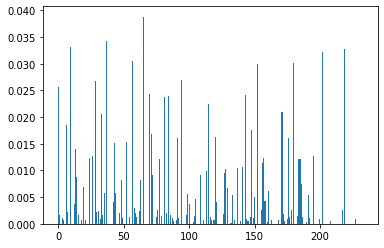

In [53]:
# RandomForestClassifier
clf = rfc.model(x_train, y_train) # if weird OS bug occures: n_jobs = -1 might not be working
eval.evaluate(clf, x_test, y_test, dataset.featureNames)

# Support Vector Machines
Support Vector Machines can make good models but need more computing time to fit data.<br>
Therefore it might be necessary to use feature-reduction before fitting the model.

In [ ]:
# Support Vector Machines
clf = spm.model(x_train_pca, y_train_pca)
eval.evaluate(clf, x_test_pca, y_test_pca, dataset.featureNames)

# Automated machine learning
There are different approaches to automize machine learning. <br>
One of which is **T**ree-based **P**ipeline **O**ptimization **T**ool which optimizes machine learning pipelines using genetic programming. <br>
There are other automated machine learning tools like Azure AutoML and Google Cloud AutoML which need further investigation.<br>
Investigate https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html, too.

In [ ]:
# TPOT http://epistasislab.github.io/tpot/using/
tpot = TPOTClassifier(generations=100, verbosity=2, memory="./tpot-memory")
tpot.fit(x_train, y_train)

In [ ]:
tpot.export("./tpot_test.py")

In [5]:
# h2o
import h2o
from h2o.automl import H2OAutoML
from numpy.random import choice

h2o.init()

h2o_train = h2o.H2OFrame(df_train)
h2o_test = h2o.H2OFrame(df_test)
# train, test = h2o_df.split_frame(ratios=[.75])

target_name = "Fixes"
x = h2o_train.columns
x.remove(target_name)

# needed for classification. If not set like that it will go for regression
h2o_train[target_name] = h2o_train[target_name].asfactor()
h2o_test[target_name] = h2o_test[target_name].asfactor()

# If you run with project_name and different seeds new Models will be added to existing leaderboard
# Still not ideal for rerunning as same models might be exploited again
aml = H2OAutoML(max_runtime_secs=60*60*5, project_name="AutoML_h2o",seed=1)
aml.train(x=x, y=target_name, training_frame=h2o_train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# Save the model
h2o.save_model(model=aml.leader, path="./models/trained_model_dumps/h2o.model", force=True)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 hours 50 mins
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,30 days
H2O_cluster_name:,H2O_from_python_Robert_2hi6yh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.580 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
23:57:19.860: AutoML: XGBoost is not available; skipping it.
23:57:19.860: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
23:57:19.860: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


NameError: name 'model' is not defined

In [6]:
predictions = aml.leader.predict(h2o_test)
numpy_predictions = predictions.as_data_frame().to_numpy()
predictions_class = predictions["predict"].as_data_frame().to_numpy()

# h2o model predicts probabilities for each class in training set. Therefore 4 values are predicted
# for each feature samle
numpy_y_test = h2o_test[target_name].as_data_frame().to_numpy()
eval.classification_report(numpy_y_test, predictions_class)
print(aml.leader.confusion_matrix(data=h2o_test))



drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


NameError: name 'accuracy_score' is not defined

In [ ]:
# GradientBoostingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

old_parameters = {
    "loss": ["deviance", "exponential"],
    'n_estimators': [10, 20, 40],
    'criterion': ['mse', 'mae'],
    'max_depth': [None, 2, 4, 8]
}
parameters = {
    "loss": ["deviance", "exponential"],
    'n_estimators': [40],
    'criterion': ['friedman_mse'],
    'max_depth': [None, 10]
}

clf = GradientBoostingClassifier(verbose=1)
grid_cv = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
grid_cv.fit(x_train, y_train)
print(f"Parameters of best model: {grid_cv.best_params_}")
print(f"Score of best model: {grid_cv.best_score_}")

clf = RandomForestClassifier(n_estimators=grid_cv.best_params_["n_estimators"], criterion=grid_cv.best_params_["criterion"], max_depth=grid_cv.best_params_["max_depth"]) 
clf.fit(x_train, y_train)
'''
y_pred = clf.predict(x_test)
y_true = [item for sublist in y_test for item in sublist]
report = classification_report(y_true, y_pred)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred) # x-Achse: Actual Values, y-Achse: Predicted Values
print(report)
print(cm)
'''

In [ ]:
# Support Vector Machines and Feature Reduction PCA

# Feature Reduction - PCA
scaler = StandardScaler()
scaler.fit(dataset.data)
x_standardized = scaler.transform(x)

# Finde die Anzahl an Dimensionen, um 95% der Varianz "zu erklären"
for n_components in range(1, 120):
    pca = PCA(n_components=n_components, copy=True)
    pca.fit(x_standardized)
    explained_variance_ratio = sum(pca.explained_variance_ratio_)
    
    print(f"Sum of Explained Variance Ratio: {round(explained_variance_ratio, 4)} with: {n_components} components.")

    if explained_variance_ratio > 0.95:
        break
    else:  
        best_explained_variance_ratio = explained_variance_ratio

print("\n\n\n")
n_components = 34
pca = PCA(n_components=n_components, copy=True)
pca.fit(x_standardized)
x_pca = pca.transform(x_standardized)
print(f"Explained Variance:\n{pca.explained_variance_}")
print(f"Explained Variance Ratio:\n{pca.explained_variance_ratio_}")
print(f"Sum of Exmplained Variance Ratio:\n{sum(pca.explained_variance_ratio_)}")


x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.30)


# Kernel: rbf, linear, poly, sigmoid
# C: low <=> smooth dec. boundary, high <=> acc. more important
# gamma: low <=> higher influence, high <=> lower influence
kernel = "poly"
C = 0.5
gamma = 1 / len(dataset.featureNames)

# GridSearch
parameters = {
    'kernel': ['kernel', 'rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': [1 / len(dataset.featureNames)],
    'C': [0.2, 0.5, 0.7],
}

clf = SVC(verbose=1)
grid_cv = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
grid_cv.fit(x_train, y_train)

# Train with best hyperparameters
clf = SVC(kernel=grid_cv.best_params_["kernel"], C=grid_cv.best_params_["C"], gamma=grid_cv.best_params_["gamma"], verbose=True)
y_train_flat = [item for sublist in y_train for item in sublist]
clf.fit(x_train, y_train_flat)





In [ ]:
# Dummy: generates predictions by respecting the training set’s class distribution.
clf = DummyClassifier(strategy="stratified")
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
score = clf.score(x_test, y_test)
print("Score: ", score)


y_true = [item for sublist in y_test for item in sublist]
report = classification_report(y_true, y_pred)
print(report)
cm = confusion_matrix(y_true, y_pred) # x-Achse: Actual Values, y-Achse: Predicted Values
print(cm)

# Dummy Classifiers
You should compare your best classifier with some simple and "stupid" strategies <br>
to make sure your classifier is somewhat better than a very simple classification strategy. <br>
You might want to run the next cell twice, if you get warning and cannot see the whole output.

In [ ]:
# Run me twice if you get warnings
import warnings
warnings.filterwarnings("ignore")
print("WARNING: Warnings will be ignored. Some metrics might be ill defined " + 
    "as no prediction of certain classes might lead to cero division. " + 
    "Please interpret metrics with causion!")

dummy_models = dummies.models(x_train, y_train)
for idx, val in enumerate(dummy_models):
    print(val.strategy)
    eval.evaluate(val.model, x_test, y_test, dataset.featureNames)
    print("\n")

warnings.filterwarnings("always")

In [ ]:
# Dummy: stratified.
clf = DummyClassifier(strategy="stratified")
clf.fit(x_train, y_train)
eval.evaluate(clf, x_test, y_test, dataset.featureNames)

y_pred = clf.predict(x_test)
score = clf.score(x_test, y_test)
print("Score: ", score)


y_true = [item for sublist in y_test for item in sublist]
report = classification_report(y_true, y_pred)
print(report)
cm = confusion_matrix(y_true, y_pred) # x-Achse: Actual Values, y-Achse: Predicted Values
print(cm)

In [ ]:
# Dummy: always predicts the most frequent label in the training set.
clf = DummyClassifier(strategy="most_frequent")
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
score = clf.score(x_test, y_test)
print("Score: ", score)


y_true = [item for sublist in y_test for item in sublist]
report = classification_report(y_true, y_pred)
print(report)
cm = confusion_matrix(y_true, y_pred) # x-Achse: Actual Values, y-Achse: Predicted Values
print(cm)

In [ ]:
# Dummy: always predicts the class that maximizes the class prior (like “most_frequent”) and predict_proba returns the class prior.
clf = DummyClassifier(strategy="prior")
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
score = clf.score(x_test, y_test)
print("Score: ", score)


y_true = [item for sublist in y_test for item in sublist]
report = classification_report(y_true, y_pred)
print(report)
cm = confusion_matrix(y_true, y_pred) # x-Achse: Actual Values, y-Achse: Predicted Values
print(cm)

In [ ]:
# Dummy: generates predictions uniformly at random.
clf = DummyClassifier(strategy="uniform")
clf.fit(x_train, y_train)

eval.evaluate(clf, x_test, y_test, dataset.featureNames)

In [ ]:
# Dummy: always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class
clf = DummyClassifier(strategy="constant", constant=0)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
score = clf.score(x_test, y_test)
print("Score: ", score)


y_true = [item for sublist in y_test for item in sublist]
report = classification_report(y_true, y_pred)
print(report)
cm = confusion_matrix(y_true, y_pred) # x-Achse: Actual Values, y-Achse: Predicted Values
print(cm)